# 車牌辨識系統

<img src="https://raw.githubusercontent.com/j82887/Artificial-Intelligence/master/00_Image/19_Implementation%20-%2004_Car_License_Plate.png" align="left" width="200">

# 一、資料前處理

## 01. 處理正樣本影像

In [90]:
import os, shutil, glob, PIL
from time import sleep
from PIL import Image   

In [ ]:
# 清空資料夾
def emptydir(dirname):
    if os.path.isdir(dirname): # 如果該資料夾是存在為True,反之為False
        shutil.rmtree(dirname) # 依序刪除該資料夾中的檔案
        sleep(2)
    os.mkdir(dirname)

In [ ]:
# src為原影像資料夾, dst為預處理的資料夾
def dirResize(src, dst):
    myfiles = glob.glob(src+'/*.jpg') # 讀取str資料夾中所有副檔名為jpg的檔案名稱
    emptydir(dst)
    for i, f in enumerate(myfiles):
        img = Image.open(f)
        img_new = img.resize((300,225),PIL.Image.ANTIALIAS) # ANTIALIAS為欠取樣，縮小影像為(300,225)
        img_new.save(dst+'/'+'resize'+str('{:0>3d}').format(i+1)+'.bmp') # 將新影像以bmp儲存至dst資料夾

In [ ]:
dirResize('carPlate_sr', 'carPlate')

## 02. 處理負樣本影像

In [ ]:
myfiles = glob.glob("carNegative_sr/*.jpg")
emptydir('carNegative')

for i, f in enumerate(myfiles):
    img = Image.open(f)
    img_new = img.resize((500, 375), PIL.Image.ANTIALIAS)
    img_new = img_new.convert('L')  #轉換為灰階
    img_new.save('carNegative/'+'negGray'+str('{:0>3d}').format(i+1)+'.bmp')

# 二、建立車牌號碼Harr特徵分類器模型

## 01. 安裝與調整套件
1. OpenCV Haar 特徵分類器模型訓練 https://github.com/sauhaardac/haar-training
2. OpenCV 官網 https://opencv.org/releases/ 中，下載```opencv-3.4.9-vc14_vc.exe```
3. 安裝```opencv-3.4.9-vc14_vc.exe```，並打開其資料夾，作以下處理：
    
    A. 將```opencv\build\x64\vc15\bin``` 中的三個檔案，複製到```haar-training\tarining```：
        a. opencv_createsamples.exe
        b. opencv_traincascade.exe
        c. opencv_world349.dll
    B. 刪除```haar-training/tarining```中的兩個檔案：
        a. createsamples.exe
        b. traincascade.exe
3. 加入正/負樣本的影像，刪除```Haar-Training-master\training\negative```與```Haar-Training-master\training\positive```原先檔案

In [77]:
import cv2
print(cv2.__version__)

4.0.0


## 02. 建立負樣本的影像標註檔

In [ ]:
fp = open('Haar-Training-master/Haar-Training-master/training/negative/bg.txt','w')
files = glob.glob('Haar-Training-master/Haar-Training-master/training/negative/*.bmp')
text = ""
for file in files:
    basename = os.path.basename(file)
    filename = 'negative/'+ basename
    text += filename + "\n"
    print(text)
    
fp.write(text)
fp.close()

## 03. 更正標註檔內正樣本的新舊車牌調整寬高比例

In [ ]:
fp = open('Haar-Training-master/Haar-Training-master/training/positive/info.txt', 'r')
lines = fp.readlines()  #讀取所有文字
rettext = ''

for line in lines:
    data = line.split(' ')
    rettext += data[0] + ' ' + data[1] + ' '

    for i in range(int(n)):
        x = float(data[2+i*4])
        y = float(data[3+i*4])
        w = float(data[4+i*4])
        h = float(data[5+i*4])
        if (w/h) < 3.8:  #如果寬長比小於3.8
            newW = h * 3.8  #寬=高*3.8
            x -= int((newW - w) / 2)  #計算新X位置
            if x<=0:  
                x=0
            w = int(newW)
        rettext = rettext+str(int(x))+' '+data[3+i*4]+' '+str(int(w))+' '+data[5+i*4]

fp.close()

fp = open('Haar-Training-master/Haar-Training-master/training/positive/info.txt', 'w')
fp.write(rettext) 
fp.close()   

In [ ]:
path = 'Haar-Training-master/Haar-Training-master/training/positive/'
fp = open(path + 'info.txt', 'r')
lines = fp.readlines()  #讀取所有文字
count =  len(glob.glob("carPlate/*.bmp")) #圖片數，產生的圖片編號由此繼續

rettext = ''  
for line in lines:
    data = line.split(' ')
    img = Image.open(path + data[0]) 
    
    x = int(data[2])  
    y = int(data[3]) 
    w = int(data[4])  
    h = int(data[5]) 
    
    reduceW = 30  #減少的的寬度
    reduceH = int(reduceW*0.75)  #減少的的高度
    multi = float(300/(300-reduceW))  #原圖與新圖比例
    neww = int(w*multi)  #新圖的寬
    newh = int(h*multi)  #新圖的高
    
    #移除左上角圖
    if (x-reduceW)>5 and (y-reduceH)>5:  #左上角有空間才移除左上角
        count += 1  #編號加1,此數值會做為檔名用
        newimg = img.crop((reduceW, reduceH, 300, 225))  #擷取圖形
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)  #放大圖形
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')  #存檔
        newx = int((x-reduceW)*multi-reduceW*(multi-1)/2)  #新圖X坐標
        newy = int((y-reduceH)*multi-reduceH*(multi-1)/2)  #新圖Y坐標            
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'  #記錄新圖資料
    
    #移除右上角圖
    if (x+w)<(300-reduceW-5) and y>(reduceW+5):
        count += 1
        newimg = img.crop((0, reduceH, (300-reduceW), 225))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int(x*multi)
        newy = int((y-reduceH)*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'
    
    #移除左下角圖
    if (x-reduceW)>5 and (y+h)<(225-reduceH-5):
        count += 1
        newimg = img.crop((reduceW, 0, 300, 225-reduceH))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int((x-reduceW)*multi)
        newy = int(y*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'
    
    #移除右下角圖
    if (x+w)<(300-reduceW-5) and (y+h)<(225-reduceH-5):
        count += 1
        newimg = img.crop((0, 0, (300-reduceW), 225-reduceH))
        newimg = newimg.resize((300, 225), Image.ANTIALIAS)
        newimg.save(path + 'rawdata/bmpraw{:0>3d}.bmp'.format(count), 'bmp')
        newx = int(x*multi)
        newy = int(y*multi)
        rettext = rettext+'rawdata/bmpraw{:0>3d}.bmp'.format(count)+' '+'1'+' '+str(newx)+' '+str(newy)+' '+str(neww)+' '+str(newh)+'\n'

fp.close()
    
fpmake = open(path + 'Info.txt', 'a')  #以新增資料方式開啟檔案
fpmake.write(rettext)  #寫入檔案
fpmake.close()

## 04. 使用Haar特徵分類器偵測車牌

[[ 63 118 151  40]]


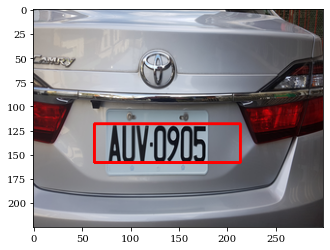

In [153]:
import cv2
import matplotlib.pyplot as plt
img_path = 'carPlate/resize001.bmp'

img = cv2.imread(img_path)
detector = cv2.CascadeClassifier("License_Plate_Haar_cascade.xml")
signs = detector.detectMultiScale(img, minSize = (76, 20), scaleFactor = 1.1, minNeighbors=10)

if len(signs) > 0:
    for (sx, sy, sw, sh) in signs:
        cv2.rectangle(img, (sx, sy), (sx+sw, sy+sh), (0, 0, 255), 2)
        print(signs)
else:
    print('沒有辨識到車牌!')

''' 
=============== 
OpenCV 讀取影像 
===============
cv2.imshow('Frame', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

影像維度： (40, 151)


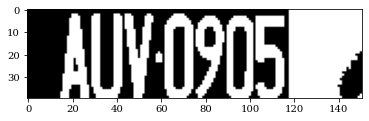

In [154]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV) 
print('影像維度：',binary_img.shape)

plt.imshow(binary_img, cmap='gray')
plt.show()

(149, 38, 2, 2)
(58, 19, 3, 5)
(103, 3, 13, 37)
(90, 3, 12, 37)
(76, 3, 13, 37)
(62, 2, 13, 38)
(44, 2, 13, 38)
(29, 2, 14, 38)
(15, 2, 13, 38)
(118, 0, 33, 40)


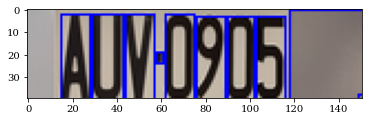

In [155]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    (x, y, w, h) = cv2.boundingRect(contours[i])
    print((x, y, w, h))
    cv2.rectangle(crop_img, (x, y), (x+w, y+h), (0, 0, 255), 1)

plt.imshow(crop_img)
plt.show()

(103, 3, 13, 37)
(90, 3, 12, 37)
(76, 3, 13, 37)
(62, 2, 13, 38)
(44, 2, 13, 38)
(29, 2, 14, 38)
(15, 2, 13, 38)


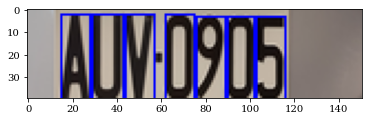

In [156]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    (x, y, w, h) = cv2.boundingRect(contours[i])
    if w>5 and 39>h>29:
        print((x, y, w, h))
        cv2.rectangle(crop_img, (x, y), (x+w, y+h), (0, 0, 255), 1)
        
plt.imshow(crop_img)
plt.show()

In [140]:
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

# 讀取數字手寫
(x_train_mnist, y_train_minst),(x_test_mnist, y_test_minst) = mnist.load_data() 

# 標籤名稱
mnist_label_name = [i for i in range(10)]
print("標籤名稱：",mnist_label_name)

# 打印維度
#print("訓練集數字手寫的類別數量:%s" %Counter(y_train_minst))
print("訓練集數字手寫的維度:",x_train_mnist.shape)
#print("測試集數字手寫的類別數量:%s" %Counter(y_test_minst))
print("測試集數字手寫的維度:",x_test_mnist.shape)

標籤名稱： [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
訓練集數字手寫的維度: (60000, 28, 28)
測試集數字手寫的維度: (10000, 28, 28)


In [141]:
# 讀取AZ_excel
AZdata = pd.read_csv('A_Z Handwritten Data.csv', header = None)
print("英文手寫維度：",AZdata.shape)

# 建立標籤名稱
AZ_label_name = [chr(i+65) for i in range(26)]
print("標籤名稱：",AZ_label_name)

# 將影像（特徵）與提取為陣列
AZ_label = np.array(AZdata)[:,0]
AZ_feature = np.array(AZdata)[:,1:785]
AZ_feature = AZ_feature.reshape(len(AZdata),28,28)

#print("英文手寫的類別數量:%s" %Counter(AZ_label))
print("英文手寫的維度:",AZ_feature.shape)

# 分割為訓練集與測試集
x_train_AZ, x_test_AZ, y_train_AZ, y_test_AZ = train_test_split(AZ_feature, AZ_label, random_state = 0, test_size = 0.4)


#print("訓練集英文手寫的類別數量:%s" %Counter(y_train_AZ))
print("訓練集英文手寫的維度:",x_train_AZ.shape)
#print("測試集英文手寫的類別數量:%s" %Counter(y_test_AZ))
print("測試集英文手寫的維度:",x_test_AZ.shape)

英文手寫維度： (372451, 785)
標籤名稱： ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
英文手寫的維度: (372451, 28, 28)
訓練集英文手寫的維度: (223470, 28, 28)
測試集英文手寫的維度: (148981, 28, 28)


## 兩個資料集合併
1. 訓練集與測試集
2. 特徵、標籤與標籤名稱

In [142]:
# 特徵合併
x_train = np.vstack([x_train_mnist, x_train_AZ])
x_test = np.vstack([x_test_mnist, x_test_AZ])

# 標籤合併
y_train = np.hstack([y_train_minst, y_train_AZ+10])
y_test = np.hstack([y_test_minst, y_test_AZ+10])

# 標籤名稱
label_name = np.hstack([mnist_label_name, AZ_label_name])
print(label_name)

# One_hot_Encoding
no_one_hot_y_train = y_train
no_one_hot_y_test = y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 正規化、轉變型態與改變維度
x_train = np.expand_dims(x_train.astype('float32')/255,-1)
x_test = np.expand_dims(x_test.astype('float32')/255,-1)
print(x_train.shape)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
(283470, 28, 28, 1)


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

cnn = Sequential()
cnn.add(Conv2D(32,(3,3),activation='relu', padding='same', input_shape=(28,28,1)))
cnn.add(Dropout(0.25))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(Dropout(0.25))
cnn.add(MaxPooling2D((2,2)))

cnn.add(Flatten())
cnn.add(Dropout(0.25))

cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.25))

cnn.add(Dense(36, activation='softmax'))

cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [61]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [62]:
history = cnn.fit(x=x_train, y=y_train, batch_size=128, epochs=20, validation_split= 0.1)

Epoch 1/20
1994/1994 [==============================] - 165s 83ms/step - loss: 0.2415 - acc: 0.9289 - val_loss: 0.1053 - val_acc: 0.9808
Epoch 2/20
1994/1994 [==============================] - 169s 85ms/step - loss: 0.1154 - acc: 0.9652 - val_loss: 0.0778 - val_acc: 0.9845
Epoch 3/20
1994/1994 [==============================] - 169s 85ms/step - loss: 0.0939 - acc: 0.9708 - val_loss: 0.0769 - val_acc: 0.9855
Epoch 4/20
1994/1994 [==============================] - 169s 85ms/step - loss: 0.0797 - acc: 0.9751 - val_loss: 0.0689 - val_acc: 0.9864
Epoch 5/20
1994/1994 [==============================] - 170s 85ms/step - loss: 0.0703 - acc: 0.9776 - val_loss: 0.0607 - val_acc: 0.9861
Epoch 6/20
1994/1994 [==============================] - 170s 85ms/step - loss: 0.0628 - acc: 0.9799 - val_loss: 0.0529 - val_acc: 0.9898
Epoch 7/20
1994/1994 [==============================] - 170s 85ms/step - loss: 0.0564 - acc: 0.9814 - val_loss: 0.0446 - val_acc: 0.9901
Epoch 8/20
1994/1994 [===================

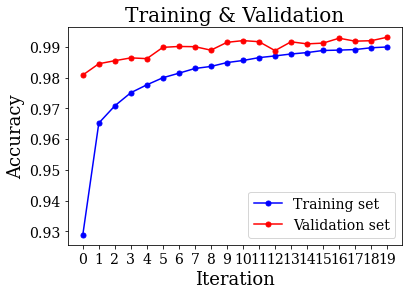

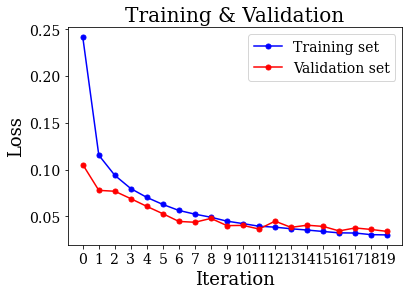

In [66]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.rcParams["font.family"] = "serif"
plt.title("Training & Validation", fontsize=20)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.plot(np.arange(len(acc)), acc,color='b', label="Training set", marker='o', markersize=5)
plt.plot(np.arange(len(val_acc)), val_acc,color='r', label="Validation set", marker='o', markersize=5)
plt.xticks(np.linspace(0,19,20,endpoint=True),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=14)
plt.show()

plt.title("Training & Validation", fontsize=20)
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.plot(np.arange(len(loss)), loss,color='b', label="Training set", marker='o', markersize=5)
plt.plot(np.arange(len(val_loss)), val_loss,color='r', label="Validation set", marker='o', markersize=5)
plt.xticks(np.linspace(0,19,20,endpoint=True),fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14)
plt.show()

In [68]:
train_loss, train_acc = cnn.evaluate(x_train, y_train)
print("訓練集的準確度為：%0.4f" %(train_acc))
print("訓練集的損失值為：%0.4f" %(train_loss))

8859/8859 [==============================] - 43s 5ms/step - loss: 0.0151 - acc: 0.9955
訓練集的準確度為：0.9955
訓練集的損失值為：0.0151


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

predict = cnn.predict(x_train)
predictions = [np.argmax(one_hot)for one_hot in predict]

Text(0.5, 1.0, 'Accuracy: 0.9955')

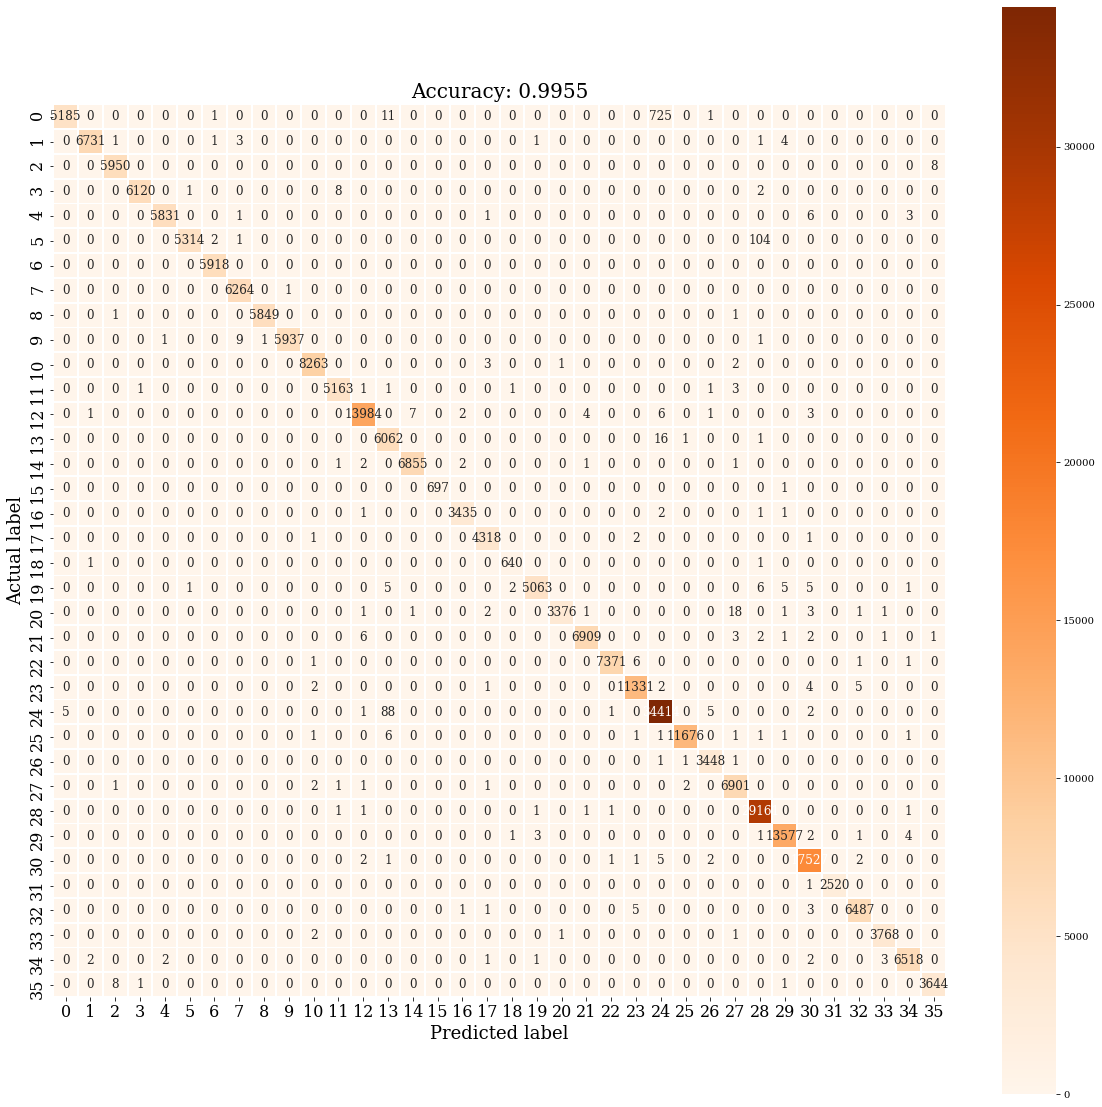

In [73]:
cm = confusion_matrix(no_one_hot_y_train, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1.0, square = True, cmap = 'Oranges',annot_kws={"size": 12})
plt.ylabel('Actual label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Accuracy: %0.4f' %(train_acc), size = 20)

In [145]:
test_loss, test_acc = cnn.evaluate(x_test, y_test)
print("訓練集的準確度為：%0.4f" %(test_acc))
print("訓練集的損失值為：%0.4f" %(test_loss))

4969/4969 [==============================] - 25s 5ms/step - loss: 0.0360 - acc: 0.9910
訓練集的準確度為：0.9910
訓練集的損失值為：0.0360


In [143]:
predict = cnn.predict(x_test)
predictions = [np.argmax(one_hot)for one_hot in predict]

Text(0.5, 1.0, 'Accuracy: 0.9910')

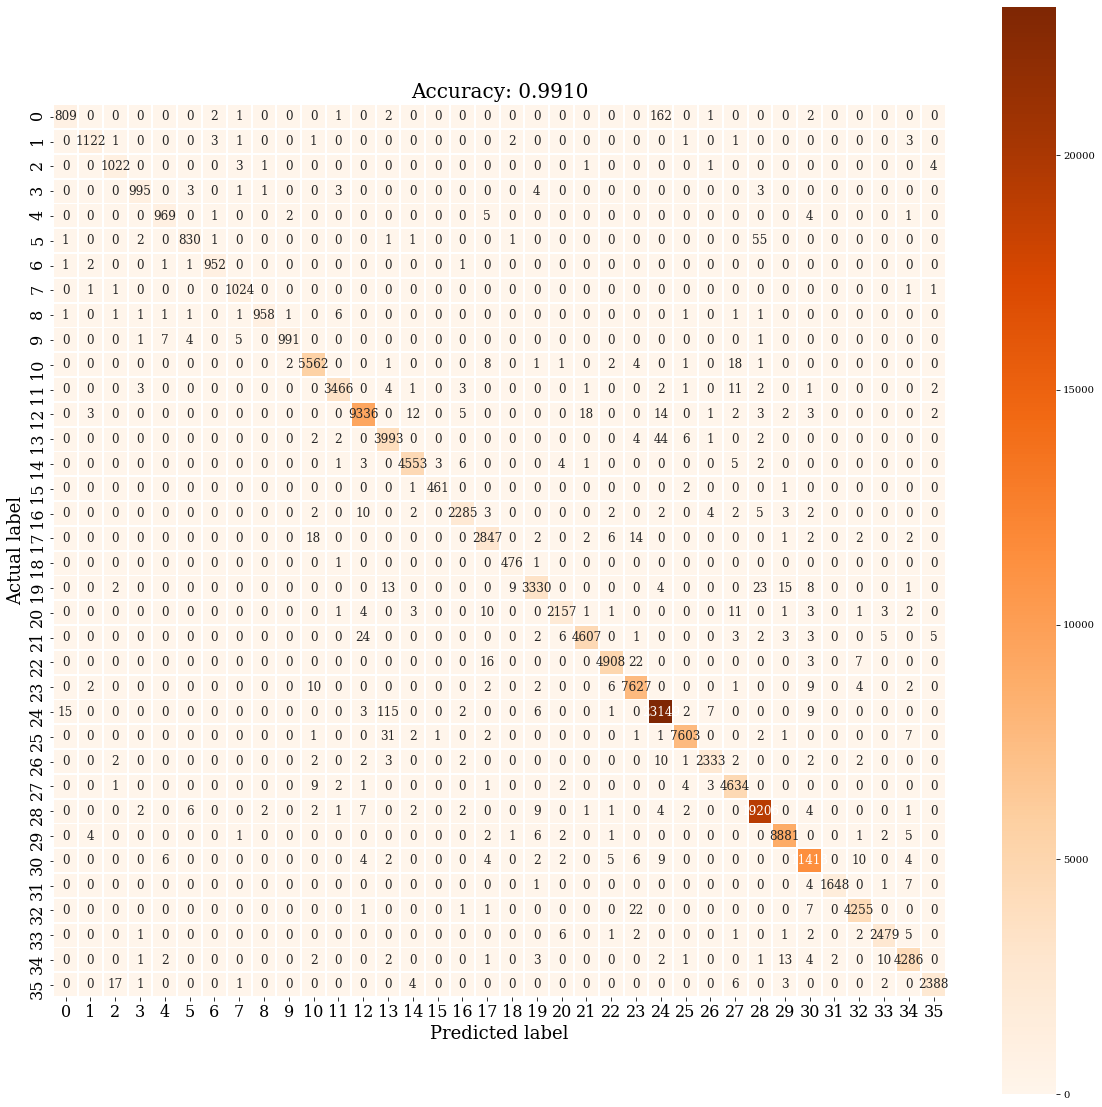

In [146]:
cm = confusion_matrix(no_one_hot_y_test, predictions)
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1.0, square = True, cmap = 'Oranges',annot_kws={"size": 12})
plt.ylabel('Actual label', size = 18)
plt.xlabel('Predicted label', size = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Accuracy: %0.4f' %(test_acc), size = 20)

In [74]:
from keras.models import load_model

cnn.save('cnn_model.h5')

from tensorflow.keras.models import load_model

cnn = load_model('cnn_model.h5')

In [166]:
img = cv2.imread(img_path)
crop_img = img[sy:sy+sh, sx:sx+sw]

gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
_, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY_INV)
                              
save_predict_name = []
contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(contours)):
    (x, y, w, h) = cv2.boundingRect(contours[i])
    if w>5 and 39>h>29:
        number = binary_img[y:y+h, x:x+w]
        pad_number = cv2.copyMakeBorder(number, 13, 13, 10, 10, borderType=cv2.BORDER_CONSTANT)
        re_number = cv2.resize(pad_number, (28, 28), interpolation=cv2.INTER_CUBIC)
        
        intput_number = np.expand_dims(np.expand_dims(re_number.astype('float32')/255,-1),0)
        predict = cnn.predict(intput_number)
        predict_name = label_name[np.argmax(predict)]
        save_predict_name.append(predict_name)
        
        #plt.imshow(re_number, cmap='gray')
        #plt.show()

# 顛倒list
name = save_predict_name[::-1]
print("".join(name))

AUY0905
